# Fitting a real plucked guitar string

- order: 1

This notebook shows how to fit the physical parameters of a guitar string to a real recording.

In [ ]:
# | hide

import jax
import jax.numpy as jnp
import numpy as np
import optax
import soundfile as sf
import soxr
from matplotlib import pyplot as plt
from scipy.signal import freqz
from tqdm import tqdm

from jaxdiffmodal.ftm import (
    string_eigenvalues,
)
from jaxdiffmodal.losses import (
    spectral_convergence_loss,
    spectral_wasserstein,
)
from jaxdiffmodal.lpc import lpc_cpu_solve
from jaxdiffmodal.utils import (
    bark2hz,
    display_audio_with_title,
    hz2bark,
    iir_filter_parallel,
    safe_log,
    tf_freqz,
    to_db,
)

In [ ]:
# | hide
sample_rate = 44100
dt = 1 / sample_rate

Load a recording of a plucked guitar string.

In [ ]:
# | code-fold: true

stiff_string_real, file_sr = sf.read("audio/G53-50205-1111-00019.wav")

if file_sr != sample_rate:
    print(f"Resampling from {file_sr} to {sample_rate}")
    stiff_string_real = soxr.resample(
        stiff_string_real,
        in_rate=file_sr,
        out_rate=sample_rate,
    )

print("The sample rate is", sample_rate)

duration = 1.0
offset = int(0.00 * file_sr)
stop = int(1 * file_sr)
stiff_string_real = stiff_string_real[offset : offset + stop]
u_stiff_string_rfft = np.fft.rfft(stiff_string_real)

The sample rate is 44100


Fit the real data using LPC to get an spectral envelope.

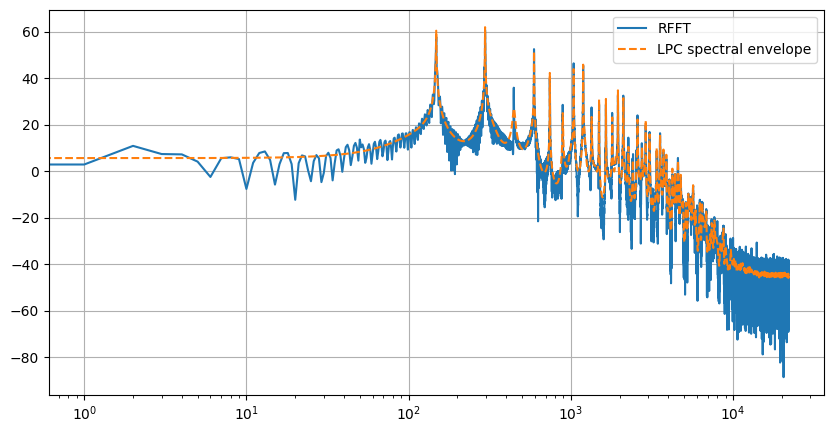

In [ ]:
# | code-fold: true

a_lpc_cpu_solve_autocorr, g_lpc_solve_autocorr = lpc_cpu_solve(
    stiff_string_real,
    512,
    method="autocorrelation",
    biased=False,
)


w, h = freqz(
    b=g_lpc_solve_autocorr,
    a=np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    worN=u_stiff_string_rfft.shape[0],
    fs=sample_rate,
)


# impulse response
H = g_lpc_solve_autocorr / np.fft.rfft(
    np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    n=sample_rate,
)
y = np.fft.irfft(H, n=sample_rate)
y_rfft = np.abs(np.fft.rfft(y))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogx(w, to_db(np.abs(u_stiff_string_rfft)), label="RFFT")
ax.semilogx(w, to_db(np.abs(h)), label="LPC spectral envelope", ls="--")
ax.grid("both")
ax.legend()

display_audio_with_title(stiff_string_real, sample_rate, "Original")
display_audio_with_title(y, sample_rate, "LPC fit")

Sample the envelope using the bark scale.

In [ ]:
# | code-fold: true

hz_range = np.array([50, 15000])
melrange = hz2bark(hz_range)
worN = bark2hz(np.linspace(melrange[0], melrange[1], 20_000))

w, h = freqz(
    g_lpc_solve_autocorr,
    a=np.concatenate([[1], a_lpc_cpu_solve_autocorr]),
    worN=worN,
    fs=sample_rate,
)

h = jnp.abs(h) / jnp.max(jnp.abs(h))

Define the initial parameters and constraints.

In [ ]:
# | code-fold: true

n_modes = 64
rng = np.random.default_rng(654)
pars = {
    "bending_stiffness": rng.normal(scale=1e-3),
    "gamma_mu": rng.uniform(size=(n_modes)),
    "zero_radii": rng.normal(size=(n_modes)).astype(np.float32),
    "zero_angles": rng.normal(size=(n_modes)).astype(np.float32),
    "Ts0": rng.normal(scale=1e-3),
    "length": 0.65,
    "z0": rng.normal(size=(n_modes, 1)).astype(np.float32),
    "gain": rng.normal(scale=1e-4),
}


def get_z0(params):
    return jax.nn.sigmoid(params["z0"])


def get_gamma_mu(params):
    return -jax.nn.relu(params["gamma_mu"])
    # return -jnp.exp(params["gamma_mu"])


def get_radii(params):
    return jax.nn.sigmoid(params["radii"])


def get_Ts0(params):
    return jax.nn.sigmoid(params["Ts0"]) * 50_000


def get_gain(params):
    return jax.nn.sigmoid(params["gain"]) * 0.001


def get_length(params):
    return jax.nn.sigmoid(params["length"])


def get_bending_stiffness(params):
    return jax.nn.sigmoid(params["bending_stiffness"]) * 10


def get_zero_radii(params):
    return jax.nn.sigmoid(params["zero_radii"])


def get_zero_angles(params):
    return jax.nn.sigmoid(params["zero_angles"])


def get_zeros(pars):
    return jax.nn.sigmoid(pars["zero_radii"]) * jnp.exp(
        2j * np.pi * jax.nn.sigmoid(pars["zero_angles"])
    )

Simulate the string using the initial parameters.

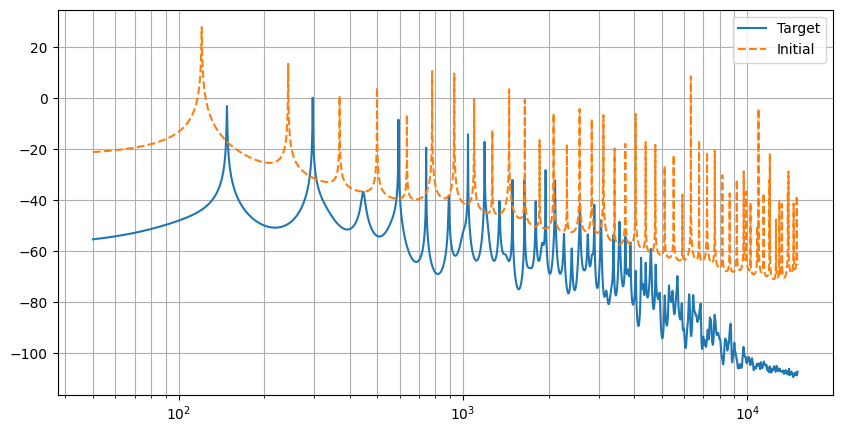

In [ ]:
# | code-fold: true


def tf_modified(
    pars,
    lambda_mu,
    dt,
):
    omega_mu_squared = (
        get_bending_stiffness(pars) * lambda_mu**2 + get_Ts0(pars) * lambda_mu
    )
    gamma_mu = get_gamma_mu(pars)
    omega_mu = jnp.sqrt(omega_mu_squared - gamma_mu**2)

    # discretise
    radius = jnp.exp(gamma_mu * dt)
    real = radius * jnp.cos(omega_mu * dt)

    zeros = get_zeros(pars)
    b1 = -2.0 * zeros.real
    b2 = zeros.real**2 + zeros.imag**2

    a1 = -2.0 * real
    a2 = radius**2

    ones = jnp.ones_like(lambda_mu)

    b = jnp.stack([ones, b1, b2], axis=-1)
    a = jnp.stack([ones, a1, a2], axis=-1)
    return b, a


def simulate_string(pars):
    lambdas = string_eigenvalues(n_modes, length=get_length(pars))
    b, a = tf_modified(pars, lambdas, dt)
    b = b * get_z0(pars) * get_gain(pars)
    h = tf_freqz(b, a, worN, sample_rate)
    pred_freq_response = jnp.mean(jnp.abs(h), axis=0)
    return pred_freq_response, b, a


initial_freq_response, b, a = simulate_string(pars)
u_stiff_string_rfft = np.fft.rfft(stiff_string_real)
fft_freqs = np.fft.rfftfreq(len(stiff_string_real), dt)

target_freq_resp = h
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.semilogx(
    worN,
    to_db(target_freq_resp),
    label="Target",
)
ax.semilogx(
    worN,
    to_db(initial_freq_response),
    label="Initial",
    ls="--",
)
ax.grid(which="both")
_ = ax.legend()

x = jnp.zeros(shape=(sample_rate), dtype=jnp.float32)
x = x.at[0].set(1.0)
mean_sol_pred = iir_filter_parallel(b, a, x).mean(axis=1)

display_audio_with_title(y, sample_rate, "Target")
display_audio_with_title(mean_sol_pred, sample_rate, "Initial")

Optimise the parameters using gradient descent.

In [ ]:
# | code-fold: true

iterations = 20_000
learning_rate = 3e-2
scheduler = optax.cosine_onecycle_schedule(
    transition_steps=iterations,
    peak_value=learning_rate,
)
optimiser = optax.chain(
    optax.clip_by_global_norm(2.0),
    optax.adam(learning_rate=scheduler),
)
state = optimiser.init(pars)


def loss_fn(pars):
    pred_freq_resp, b, a = simulate_string(pars)

    log_diff = safe_log(pred_freq_resp) - safe_log(target_freq_resp)
    log_l1_loss = jnp.mean(
        jnp.abs(
            log_diff,
        ),
    )
    sc_loss = spectral_convergence_loss(
        pred_freq_resp,
        target_freq_resp,
    )
    ot_loss = jnp.mean(
        spectral_wasserstein(
            pred_freq_resp,
            target_freq_resp,
            is_mag=True,
        )
    )

    return log_l1_loss * 0.1 + sc_loss + ot_loss


@jax.jit
def train_step(pars, state):
    loss, grads = jax.value_and_grad(loss_fn)(pars)
    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


bar = tqdm(range(iterations))
for i in bar:
    pars, state, loss = train_step(pars, state)
    bar.set_description(
        f"Loss: {loss:.3f}, length: {get_length(pars):.3f}, Ts0: {get_Ts0(pars):.3f}, bending stiffness: {get_bending_stiffness(pars):.3f}"
    )

Loss: 0.176, length: 0.676, Ts0: 40033.289, bending stiffness: 0.384: 100%|██████████| 20000/20000 [00:34<00:00, 585.55it/s] 


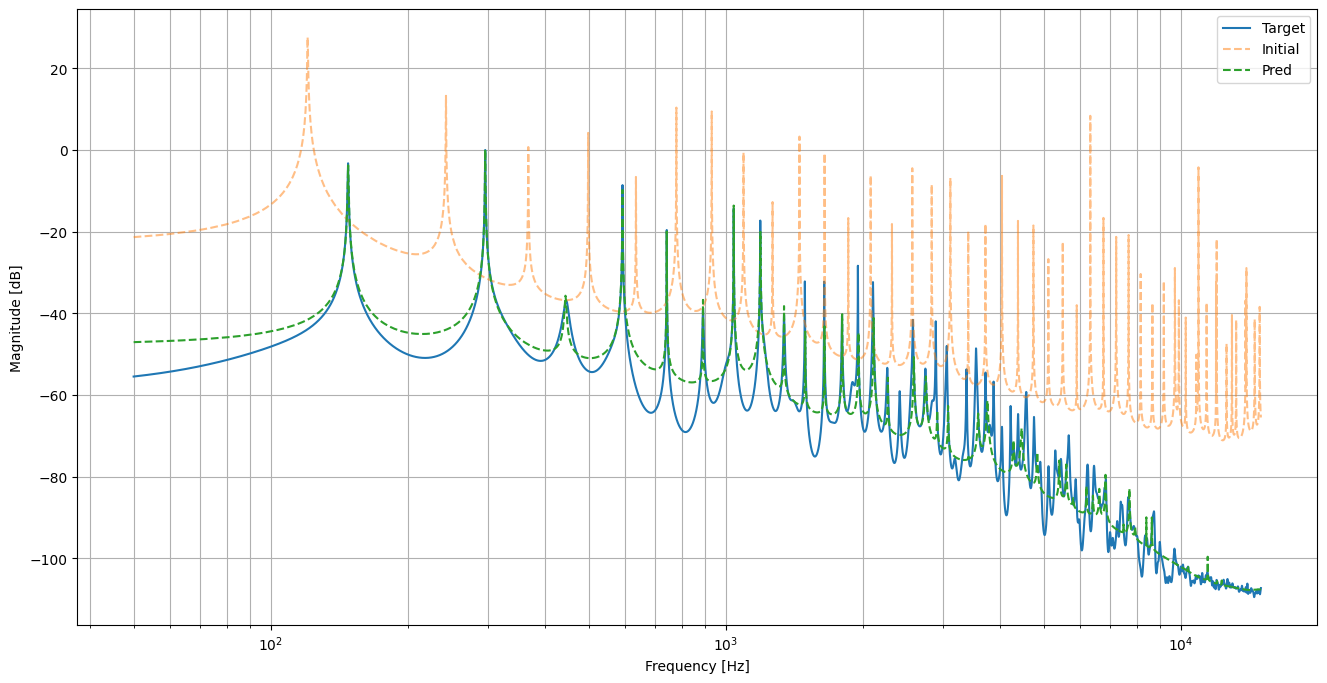

In [ ]:
# | echo: false

pred_freq_response, b, a = simulate_string(pars)
u_stiff_string_rfft = np.fft.rfft(stiff_string_real)
fft_freqs = np.fft.rfftfreq(len(stiff_string_real), 1 / sample_rate)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.semilogx(
    worN,
    to_db(target_freq_resp),
    label="Target",
)
ax.semilogx(
    worN,
    to_db(initial_freq_response),
    label="Initial",
    ls="--",
    alpha=0.5,
)
ax.semilogx(
    worN,
    to_db(pred_freq_response),
    label="Pred",
    ls="--",
)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude [dB]")
ax.grid(which="both")
_ = ax.legend(loc="upper right")

x = jnp.zeros(shape=(sample_rate), dtype=jnp.float32)
x = x.at[0].set(1.0)
mean_sol_pred = iir_filter_parallel(b, a, x).mean(axis=1)

display_audio_with_title(y, sample_rate, "Target")
display_audio_with_title(mean_sol_pred, sample_rate, "Optimised")